In [1]:
#importamos las librerias
import torch
import torchvision
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import random

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import zipfile

# Ruta al archivo zip que deseas descomprimir
zip_file_path = '/content/drive/MyDrive/prueba_final.zip'

# Directorio de destino donde se extraerán los archivos
extract_dir = '/content/zip_extraido'

# Crear el directorio de destino si no existe
os.makedirs(extract_dir, exist_ok=True)

# Descomprimir el archivo zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("¡Descompresión completada!")

¡Descompresión completada!


In [22]:
import os
import random
from PIL import Image
import numpy as np
import xml.etree.ElementTree as ET

import os
import random
from PIL import Image
import numpy as np
import xml.etree.ElementTree as ET

def cargar_dataset_train(ruta_dataset, ruta_annotations, tamaño_imagen=(50, 50)):
    dataset = []

    # Recorrer las clases en el dataset
    for clase in os.listdir(ruta_dataset):
        ruta_clase = os.path.join(ruta_dataset, clase)
        ruta_clase_annotations = os.path.join(ruta_annotations, clase)

        if os.path.isdir(ruta_clase):
            with os.scandir(ruta_clase) as entries:
                for entry in entries:
                    if entry.is_file() and entry.name.endswith(('.png', '.jpg', '.jpeg')):
                        imagen_ruta = os.path.join(ruta_clase, entry.name)
                        imagen = Image.open(imagen_ruta).convert('RGB')

                        # Preparar la ruta a la anotación correspondiente
                        nombre_base = os.path.splitext(entry.name)[0]
                        archivo_annotation = nombre_base + '.xml'
                        annotation_ruta = os.path.join(ruta_clase_annotations, archivo_annotation)

                        try:
                            etiqueta = parse_xml_annotation(annotation_ruta)
                        except FileNotFoundError:
                            print(f"No se encontró la anotación para {entry.name}")
                            continue

                        # Procesamiento de la imagen
                        imagen = np.array(imagen) / 255.0
                        imagen_pil = Image.fromarray((imagen * 255).astype(np.uint8))
                        imagen_resized = imagen_pil.resize(tamaño_imagen)
                        dataset.append((imagen_resized, etiqueta))

    random.shuffle(dataset)
    return dataset

def parse_xml_annotation(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    annotation = {
        'annotation': {
            'folder': root.find('folder').text,
            'filename': root.find('filename').text,
            'source': {
                'database': root.find('source/database').text,
                'annotation': root.find('source/annotation').text,
                'image': root.find('source/image').text
            },
            'size': {
                'width': root.find('size/width').text,
                'height': root.find('size/height').text,
                'depth': '3'
            },
            'segmented': root.find('segmented').text,
            'object': [{
                'name': obj.find('name').text,
                'pose': obj.find('pose').text if obj.find('pose') is not None else None,
                'truncated': obj.find('truncated').text,
                'occluded': obj.find('occluded').text,
                'bndbox': {'xmin': obj.find('bndbox/xmin').text, 'ymin': obj.find('bndbox/ymin').text, 'xmax': obj.find('bndbox/xmax').text, 'ymax': obj.find('bndbox/ymax').text},
                'difficult': obj.find('difficult').text
            } for obj in root.findall('object')]
        }
    }
    return annotation

# Ejemplo de uso
ruta_dataset = '/content/zip_extraido/prueba_final/perros_dataset'
ruta_annotations = '/content/zip_extraido/prueba_final/anotaciones_perros'
dataset = cargar_dataset_train(ruta_dataset, ruta_annotations)


No se encontró la anotación para cachorro-beagle-tricolor-planteando-lindo-perrito-o-mascota-blanco-braun-negro-jugando-sobre-fondo-amarillo-parece-tranquilo-confiado-foto-estudio-concepto-movimiento-movimiento-accion-espacio-negativo_155003-3394 - copia.jpg


In [23]:
classes = ('Afgano', 'Beagle', 'Collie', 'Coocker', 'German_Pointer', 'Schnauzer')

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import random

def get_sample(ix):
  img, label = dataset[ix]
  # print("+++"*10)
  # print(img)
  # print("..."*10)
  # print(label)
  # print("+++"*10)
  img_np = np.array(img)
  anns = label['annotation']['object']
  if type(anns) is not list:
    anns = [anns]
  labels = np.array([classes.index(ann['name']) for ann in anns])
  bbs = [ann['bndbox'] for ann in anns]
  bbs = np.array([[int(float(bb['xmin'])), int(float(bb['ymin'])), int(float(bb['xmax'])) - int(float(bb['xmin'])), int(float(bb['ymax'])) - int(float(bb['ymin']))] for bb in bbs])
  anns = (labels, bbs)
  return img_np, anns


def plot_anns(img, anns, ax=None, bg=-1, classes=classes):
  # anns is a tuple with (labels, bbs)
  # bbs is an array of bounding boxes in format [x_min, y_min, width, height]
  # labels is an array containing the label
  if not ax:
    fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(img)
  labels, bbs = anns
  for lab, bb in zip(labels, bbs):
    if bg == -1 or lab != bg:
      bb = torch.tensor(bb)
      x, y, w, h = bb.detach().numpy()
      rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
      text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
      text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
      ax.add_patch(rect)

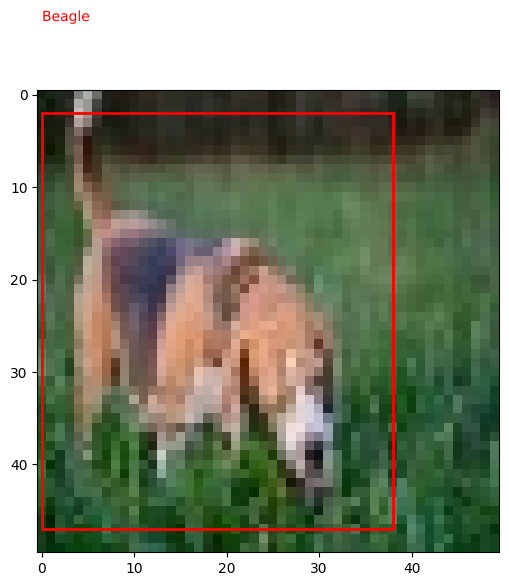

In [25]:
img_np, anns = get_sample(8000)
plot_anns(img_np, anns)
plt.show()

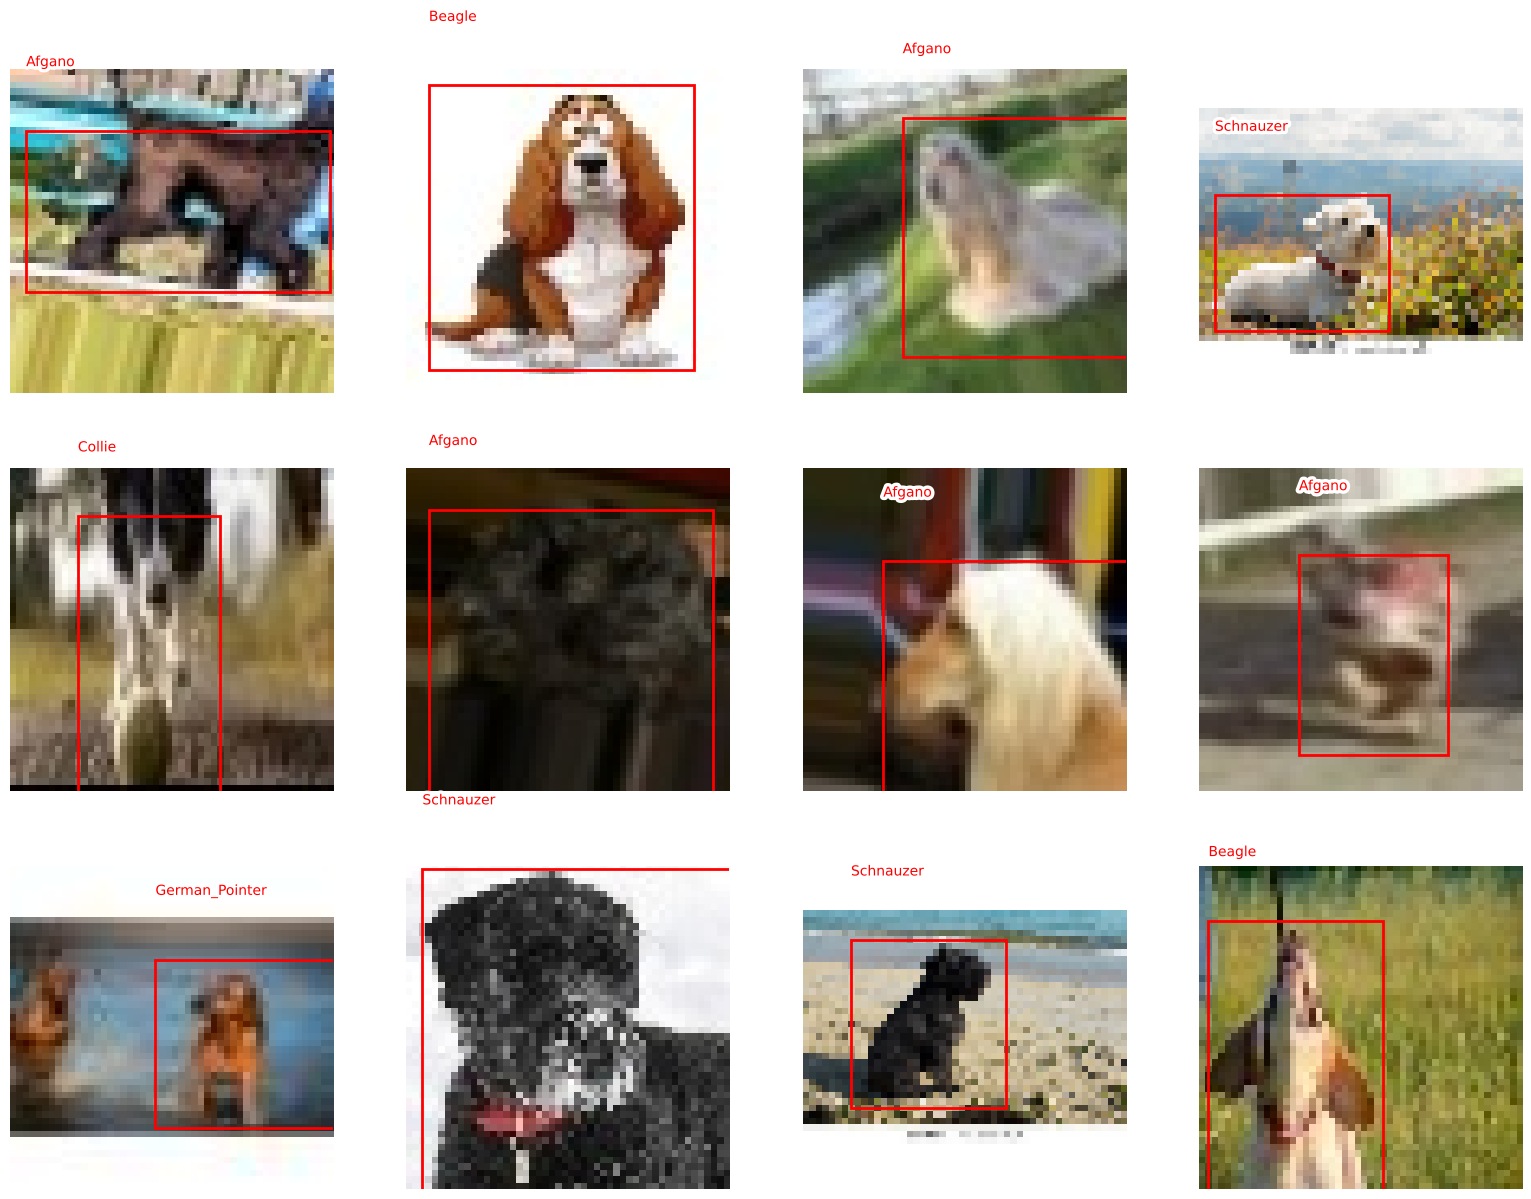

In [27]:
r, c = 3, 4
fig = plt.figure(figsize=(4*c, 4*r))
for _r in range(r):
    for _c in range(c):
        ax = plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(dataset)-1)
        img_np, anns = get_sample(ix)
        plot_anns(img_np, anns, ax)
        plt.axis("off")
plt.tight_layout()
plt.show()

In [28]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 67.4MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [41]:
img_np, anns = get_sample(20500)
print(img_np, anns)

[[[176 133  99]
  [163 125  89]
  [178 144 109]
  ...
  [ 21  32  15]
  [  8  26   0]
  [ 14  35   4]]

 [[178 136  98]
  [169 129  93]
  [172 138 101]
  ...
  [ 19  32  12]
  [ 49  68  40]
  [ 42  66  32]]

 [[178 137  93]
  [151 112  69]
  [172 135  93]
  ...
  [ 20  35  12]
  [ 24  45  14]
  [ 31  57  20]]

 ...

 [[196 180 165]
  [207 191 176]
  [202 186 173]
  ...
  [207 185 161]
  [207 185 161]
  [208 186 162]]

 [[190 178 164]
  [191 179 165]
  [192 178 165]
  ...
  [218 196 173]
  [209 187 166]
  [208 187 166]]

 [[191 182 167]
  [192 183 168]
  [194 182 168]
  ...
  [218 196 173]
  [208 187 168]
  [208 187 168]]] (array([2]), array([[ 2, 10, 39, 30]]))


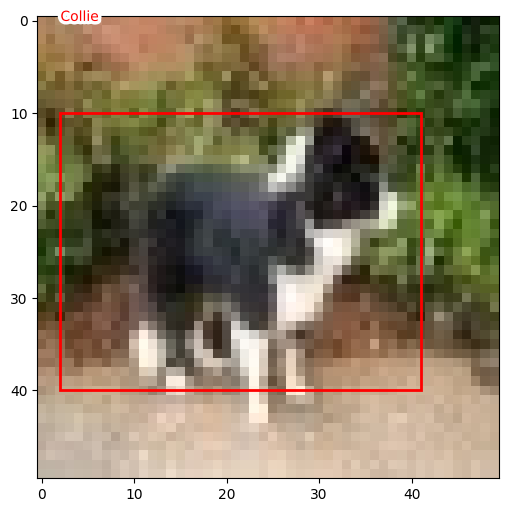

In [42]:
plot_anns(img_np, anns)
plt.show()

In [43]:
model.eval()
outputs = model([torch.tensor(img_np / 255.).permute(2,0,1).float()])
outputs

[{'boxes': tensor([[ 9.8479, 15.7297, 29.9454, 43.5604],
          [ 7.7983,  9.6204, 32.5970, 42.0993],
          [ 7.7535, 10.2406, 32.7743, 44.1813],
          [ 6.7404,  9.4710, 33.7638, 43.2942],
          [29.4360, 10.0917, 36.6416, 23.6990],
          [13.6509,  6.7730, 19.8609, 15.0745],
          [ 8.3498,  6.2230, 33.4012, 43.0907],
          [ 9.9362, 31.6400, 13.8618, 40.7957],
          [ 9.3151, 14.9728, 30.4229, 43.7457],
          [10.4634, 14.8197, 29.9953, 37.4406],
          [ 7.9034,  7.7898, 33.5285, 41.7450],
          [ 8.6192, 20.8728, 32.8888, 40.8545]], grad_fn=<StackBackward0>),
  'labels': tensor([62, 18, 19, 21,  1, 56, 25,  3, 15, 47, 17,  3]),
  'scores': tensor([0.3591, 0.1785, 0.1690, 0.1310, 0.1057, 0.0993, 0.0890, 0.0791, 0.0682,
          0.0629, 0.0559, 0.0501], grad_fn=<IndexBackward0>)}]

In [45]:
classes_perro = ['Afgano', 'Beagle', 'Collie', 'Coocker', 'German_Pointer', 'Schnauzer']

IndexError: list index out of range

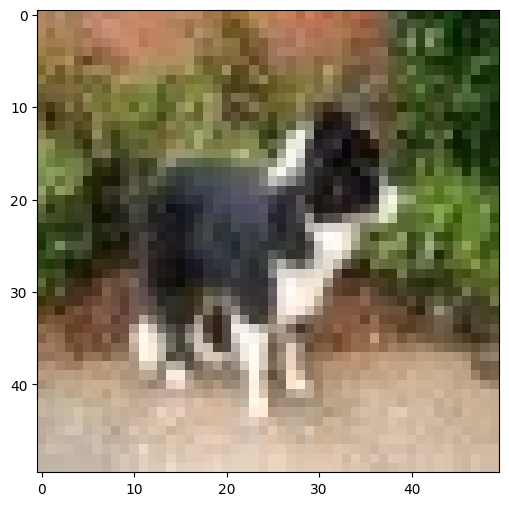

In [46]:
img_np, anns = get_sample(20500)
# nos quedamos con la primera detección
bb = outputs[0]['boxes'][0].long().tolist()
bb = [bb[0], bb[1], bb[2]-bb[0], bb[3]-bb[1]]
plot_anns(img_np, (outputs[0]['labels'][:1], [bb]), classes=classes_perro)
plt.show()